# FXa: evaluations using k conformations 10x4CV
## Data load and preprocessing

In [1]:
%run ./1_Helper_functions.ipynb

In [2]:
%load_ext rpy2.ipython

In [3]:
protein_name='fxa'
file_name = '../../../FXa/ANALISIS/6_Machine_Learning_Models/' + \
'df_DkSc_results_COCRYS_DEKOIS_DUD.pkl'
X_merged_dksc = pd.read_pickle(file_name)
y_true_merged = X_merged_dksc['activity']
X_merged_dksc = X_merged_dksc.drop('activity', axis=1)
X_merged_dksc.shape

# Simplify the names
X = X_merged_dksc.values
y = y_true_merged.values


R_a = round(y.sum() / len(y), 2)
print(X.shape)
print(y.sum())
print('Ra =', R_a)

(6233, 136)
300
Ra = 0.05


## Estimators
### ML Classifiers

In [4]:
from sklearn.dummy import DummyClassifier

hyparams = {'strategy': "stratified", "random_state": 42}
dclf = DummyClassifier(**hyparams)

In [5]:
from sklearn.linear_model import LogisticRegression 

hyparams = {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear', 'max_iter':400}
lr = LogisticRegression(**hyparams)

In [6]:
from xgboost import XGBClassifier

hyparams ={'subsample': 0.5, 'n_estimators': 200, 
           'max_depth': 10, 'learning_rate': 0.1, 
           'gamma': 1, 'colsample_bytree': 0.5, 'alpha': 0.5}
xgb = XGBClassifier(**hyparams)

In [7]:
# ML Classifier
ml_classifiers = {
    'lr': lr,
    'xgb': xgb,
    'dclf': dclf
}

# update names
ml_classifiers = {f'ml_{name}': clf 
                for name, clf in ml_classifiers.items()}

### Consensus Scorings

In [8]:
%run ../6_Machine_Learning_Models/5_Helper_Consensus_Scoring.ipynb

cs_functions = {
    'MEAN': get_mean_score,
    'MAX': get_max_score,
    'MIN': get_min_score
}

# update names
cs_functions = {f'cs_{name}': func 
                for name, func in cs_functions.items()}

### Estimators dictionary 

In [9]:
estimators = {**ml_classifiers, **cs_functions}

In [10]:
full_names = ['Log. Reg.', 'XGB', 'DummyClf', 
              'csMEAN', 'csMAX', 'csMIN']
# Nombr'e al reves a csMAX con csMEAN el orden debe ser:
# MEAN, MAX, MIN
new_names = dict(zip(estimators.keys(), full_names))

### Evaluation metrics 

In [11]:
metrics=dict(roc_auc = {'metric_name': 'roc_auc'},
             nef_12_Ra = {'metric_name': 'ef', 
                    'fraction': R_a, 'method':'normalized'},
             pROC = {'metric_name': 'p_roc'},
             pr_auc = {'metric_name': 'pr_auc'}
            )

# 10x4 CV with k conformations

## k-random conformations

In [12]:
# Save the results to a file to ommit repeate the analysis
@run_or_load_joblib
def nk_rep_cross_validation_SAVE(filename, **kwargs):
    return nk_rep_cross_validation(**kwargs)

In [13]:
main_dir = f'./cachedir/k_confs_10x4cv/{protein_name}'
max_confs = X.shape[1]
k_values = [1, 2, 4, 8, 16, 32, 64, 128,  max_confs]

n_reps = 10
n_splits = 4
full_results = {}

## Random Selection

In [14]:
%%time

# ************
test_name = 'random'
full_results[test_name] = {}
# ************
evaluation_name = f'k-confs-{test_name}_{n_reps}_reps'

for k in k_values:
    # Name the output file
    filename = f'{main_dir}/{evaluation_name}_{protein_name}_nConfs-{k}'
    
    results = nk_rep_cross_validation_RANDOM_CONFS_SAVE(
                                filename=filename,
                                X=X, y=y, 
                                n_reps=n_reps, n_splits=n_splits,
                                k=k, max_confs=max_confs, 
                                metrics=metrics)
        
    print(f'Evaluation with k={k} finished.')
    # *******************************
    full_results[test_name][f'k_{k}'] = results


File loaded: ./cachedir/k_confs_10x4cv/fxa/k-confs-random_10_reps_fxa_nConfs-1
Evaluation with k=1 finished.
File loaded: ./cachedir/k_confs_10x4cv/fxa/k-confs-random_10_reps_fxa_nConfs-2
Evaluation with k=2 finished.
File loaded: ./cachedir/k_confs_10x4cv/fxa/k-confs-random_10_reps_fxa_nConfs-4
Evaluation with k=4 finished.
File loaded: ./cachedir/k_confs_10x4cv/fxa/k-confs-random_10_reps_fxa_nConfs-8
Evaluation with k=8 finished.
File loaded: ./cachedir/k_confs_10x4cv/fxa/k-confs-random_10_reps_fxa_nConfs-16
Evaluation with k=16 finished.
File loaded: ./cachedir/k_confs_10x4cv/fxa/k-confs-random_10_reps_fxa_nConfs-32
Evaluation with k=32 finished.
File loaded: ./cachedir/k_confs_10x4cv/fxa/k-confs-random_10_reps_fxa_nConfs-64
Evaluation with k=64 finished.
File loaded: ./cachedir/k_confs_10x4cv/fxa/k-confs-random_10_reps_fxa_nConfs-128
Evaluation with k=128 finished.
File loaded: ./cachedir/k_confs_10x4cv/fxa/k-confs-random_10_reps_fxa_nConfs-136
Evaluation with k=136 finished.
CPU t

### ROC-AUC

In [15]:
df_random = get_group_stats(full_results[test_name], metric_name='roc_auc', indexes_values=k_values)
df_random = df_random.replace(new_names)

R[write to console]: Registering fonts with R

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: Loading required package: ggplot2

R[write to console]: 
Attaching package: ‘matrixStats’


R[write to console]: The following object is masked from ‘package:dplyr’:

    count


R[write to console]: The following object is masked from ‘package:plyr’:

    count


R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

R[write to console]: ✔ tibble  3.0.4     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0
✔ purrr   0.3.2     

R[write to console]: ── Co

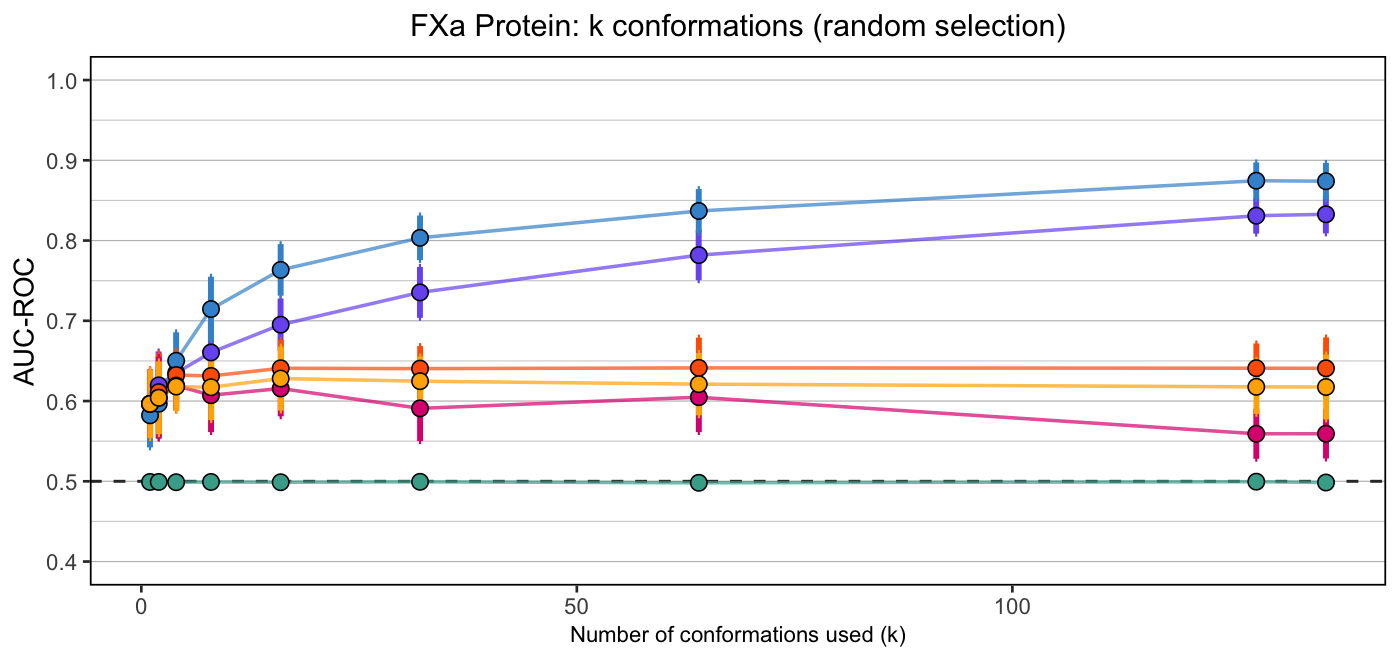

In [16]:
%%R -i full_names -i df_random  -w 7 -h 3.3 --units in -r 200

source('./plotSwarmBox.R')
metric_name <- 'AUC-ROC'

df <- df_random
cbbPalette <- c( '#785EF0', '#3F93D2', '#44AA99', '#FE6100', '#DC267F', '#FFB000')
names(cbbPalette) <- full_names

plot_lines(df, cbbPalette, y_min=0.4, y_max=1., line_size=0.6, point_size=2.5,
               y_label=metric_name, base_h_line=0.5, switch_x=FALSE, 
               x_label="Number of conformations used (k)") +
ggtitle('FXa Protein: k conformations (random selection)')

### NEF R_a

In [17]:
df_random = get_group_stats(full_results[test_name], metric_name='nef_12_Ra', indexes_values=k_values)
df_random = df_random.replace(new_names)

In [18]:
%%R -i full_names -i df_random  -w 7 -h 3.3 --units in -r 200

source('./plotSwarmBox.R')
metric_name <- 'NEF (5% = Ra)'

df <- df_random
cbbPalette <- c( '#785EF0', '#3F93D2', '#44AA99', '#FE6100', '#DC267F', '#FFB000')
names(cbbPalette) <- full_names

plot_lines(df, cbbPalette, y_min=0.0, y_max=.8, line_size=0.8, point_size=2.5, 
               y_label=metric_name, base_h_line=R_a, switch_x=FALSE, #legend.position='bottom',
               x_label="Number of conformations used")  

R[write to console]: Error in new_data_frame(list(yintercept = yintercept)) : 
  objeto 'R_a' no encontrado

R[write to console]: Además: 
R[write to console]: There were 12 warnings (use warnings() to see them)
R[write to console]: 




Error in new_data_frame(list(yintercept = yintercept)) : 
  objeto 'R_a' no encontrado


## REF preselected => XGB

In [19]:
# Open RFE_estimator
dataset = 'MERGED'
model_name = 'XGB_tree'
split = 'random'
# filename = f'../../../FXa/ANALISIS/6_Machine_Learning_Models/ml_models/RFECV_selector_{model_name}_{dataset}_{split}_split.joblib'
filename = f'./rfe_selectors/RFE_xgb_{protein_name}.joblib'
# RFE selector LogReg Random split
rfe_selector = joblib.load(filename)
df_ranks = pd.DataFrame({'pdb_id': X_merged_dksc.columns, 'rfe_ranking': rfe_selector.ranking_})
df_ranks = df_ranks.sort_values('rfe_ranking')

In [20]:
rfe_selector

RFE(estimator=XGBClassifier(alpha=0.5, base_score=None, booster=None,
                            colsample_bylevel=None, colsample_bynode=None,
                            colsample_bytree=0.5, gamma=1, gpu_id=None,
                            importance_type='gain',
                            interaction_constraints=None, learning_rate=0.1,
                            max_delta_step=None, max_depth=10,
                            min_child_weight=None, missing=nan,
                            monotone_constraints=None, n_estimators=200,
                            n_jobs=None, num_parallel_tree=None,
                            random_state=None, reg_alpha=None, reg_lambda=None,
                            scale_pos_weight=None, subsample=0.5,
                            tree_method=None, validate_parameters=None,
                            verbosity=None),
    n_features_to_select=1, verbose=2)

In [21]:
%%time

# ************
test_name = 'RFExgb'
full_results[test_name] = {}
# ************
evaluation_name = f'k-confs-{test_name}_{n_reps}_reps'

for k in k_values:
    # Name the output file
    filename = f'{main_dir}/{evaluation_name}_{protein_name}_nConfs-{k}'
    # Get the conformations using the selector
    conformations = df_ranks.index[:k]
    X_sub = X[:, conformations]
    # Do the analysis
    result = nk_rep_cross_validation_SAVE(
                 filename=filename, 
                 estimators=estimators, 
                 X=X_sub, y=y, metrics=metrics, 
                 n_repeats=n_reps,
                 y_preds_return=False,
                 random_state=42
            )
    print(f'Evaluation with k={k} finished.')
    # *******************************
    full_results[test_name][f'k_{k}'] = result


File loaded: ./cachedir/k_confs_10x4cv/fxa/k-confs-RFExgb_10_reps_fxa_nConfs-1
Evaluation with k=1 finished.
File loaded: ./cachedir/k_confs_10x4cv/fxa/k-confs-RFExgb_10_reps_fxa_nConfs-2
Evaluation with k=2 finished.
File loaded: ./cachedir/k_confs_10x4cv/fxa/k-confs-RFExgb_10_reps_fxa_nConfs-4
Evaluation with k=4 finished.
File loaded: ./cachedir/k_confs_10x4cv/fxa/k-confs-RFExgb_10_reps_fxa_nConfs-8
Evaluation with k=8 finished.
File loaded: ./cachedir/k_confs_10x4cv/fxa/k-confs-RFExgb_10_reps_fxa_nConfs-16
Evaluation with k=16 finished.
File loaded: ./cachedir/k_confs_10x4cv/fxa/k-confs-RFExgb_10_reps_fxa_nConfs-32
Evaluation with k=32 finished.
File loaded: ./cachedir/k_confs_10x4cv/fxa/k-confs-RFExgb_10_reps_fxa_nConfs-64
Evaluation with k=64 finished.
File loaded: ./cachedir/k_confs_10x4cv/fxa/k-confs-RFExgb_10_reps_fxa_nConfs-128
Evaluation with k=128 finished.
File loaded: ./cachedir/k_confs_10x4cv/fxa/k-confs-RFExgb_10_reps_fxa_nConfs-136
Evaluation with k=136 finished.
CPU t

## REF preselected => Random Forest (duplicated dropped)

In [22]:
# Open RFE_estimator
dataset = 'MERGED'
model_name = 'RandomForest'
split = 'random'
filename = f'../../../FXa/ANALISIS/6_Machine_Learning_Models/ml_models/RFECV_selector_{model_name}_{dataset}_{split}_split.joblib'
# RFE selector LogReg Random split
rfe_selector = joblib.load(filename)
rfe_selector.ranking_
df_ranks = pd.DataFrame({'pdb_id': X_merged_dksc.columns, 'rfe_ranking': rfe_selector.ranking_})
df_ranks = df_ranks.sort_values('rfe_ranking')

df_ranks_dropped = df_ranks.drop_duplicates('rfe_ranking')

/Users/joelricci/miniconda/envs/mds/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.22.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/joelricci/miniconda/envs/mds/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.22.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/joelricci/miniconda/envs/mds/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator RFECV from version 0.22.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [23]:
%%time

# ************
test_name = 'RFE-Drop-Rforest'
full_results[test_name] = {}
# ************
evaluation_name = f'k-confs-{test_name}_{n_reps}_reps'

for k in k_values:
    # Name the output file
    filename = f'{main_dir}/{evaluation_name}_{protein_name}_nConfs-{k}'
    # Get the conformations using the selector
    if k < df_ranks.shape[0]:
        conformations = df_ranks_dropped.index[:k]
    else:
        conformations = df_ranks.index[:k]
    X_sub = X[:, conformations]
    # Do the analysis
    result = nk_rep_cross_validation_SAVE(
                 filename=filename, 
                 estimators=estimators, 
                 X=X_sub, y=y, metrics=metrics, 
                 n_repeats=n_reps,
                 y_preds_return=False,
                 random_state=42
            )
    print(f'Evaluation with k={k} finished.')
    # *******************************
    full_results[test_name][f'k_{k}'] = result


File loaded: ./cachedir/k_confs_10x4cv/fxa/k-confs-RFE-Drop-Rforest_10_reps_fxa_nConfs-1
Evaluation with k=1 finished.
File loaded: ./cachedir/k_confs_10x4cv/fxa/k-confs-RFE-Drop-Rforest_10_reps_fxa_nConfs-2
Evaluation with k=2 finished.
File loaded: ./cachedir/k_confs_10x4cv/fxa/k-confs-RFE-Drop-Rforest_10_reps_fxa_nConfs-4
Evaluation with k=4 finished.
File loaded: ./cachedir/k_confs_10x4cv/fxa/k-confs-RFE-Drop-Rforest_10_reps_fxa_nConfs-8
Evaluation with k=8 finished.
File loaded: ./cachedir/k_confs_10x4cv/fxa/k-confs-RFE-Drop-Rforest_10_reps_fxa_nConfs-16
Evaluation with k=16 finished.
File loaded: ./cachedir/k_confs_10x4cv/fxa/k-confs-RFE-Drop-Rforest_10_reps_fxa_nConfs-32
Evaluation with k=32 finished.
File loaded: ./cachedir/k_confs_10x4cv/fxa/k-confs-RFE-Drop-Rforest_10_reps_fxa_nConfs-64
Evaluation with k=64 finished.
File loaded: ./cachedir/k_confs_10x4cv/fxa/k-confs-RFE-Drop-Rforest_10_reps_fxa_nConfs-128
Evaluation with k=128 finished.
File loaded: ./cachedir/k_confs_10x4cv

## Best conformations (single AUC-ROC score)

In [24]:
# Import the conformations features table
file=f'./TABLE_Confs_Features_and_performances_{protein_name}.pkl'
with open(file, 'rb') as f:
    df_feat = pickle.load(f)

# Reset index to access each conformation per inx position
df_feat = df_feat.reset_index()

In [25]:
%%time

# ************
test_name = 'singConfAUC'
full_results[test_name] = {}

df_ranks = df_feat.sort_values('AUC-ROC', ascending=False)

# ************
evaluation_name = f'k-confs-{test_name}_{n_reps}_reps'

for k in k_values:
    # Name the output file
    filename = f'{main_dir}/{evaluation_name}_{protein_name}_nConfs-{k}'
    # Get the conformations using the selector
    conformations = df_ranks.index[:k]
    X_sub = X[:, conformations]
    # Do the analysis
    result = nk_rep_cross_validation_SAVE(
                 filename=filename, 
                 estimators=estimators, 
                 X=X_sub, y=y, metrics=metrics, 
                 n_repeats=n_reps,
                 y_preds_return=False,
                 random_state=42
            )
    print(f'Evaluation with k={k} finished.')
    # *******************************
    full_results[test_name][f'k_{k}'] = result


File loaded: ./cachedir/k_confs_10x4cv/fxa/k-confs-singConfAUC_10_reps_fxa_nConfs-1
Evaluation with k=1 finished.
File loaded: ./cachedir/k_confs_10x4cv/fxa/k-confs-singConfAUC_10_reps_fxa_nConfs-2
Evaluation with k=2 finished.
File loaded: ./cachedir/k_confs_10x4cv/fxa/k-confs-singConfAUC_10_reps_fxa_nConfs-4
Evaluation with k=4 finished.
File loaded: ./cachedir/k_confs_10x4cv/fxa/k-confs-singConfAUC_10_reps_fxa_nConfs-8
Evaluation with k=8 finished.
File loaded: ./cachedir/k_confs_10x4cv/fxa/k-confs-singConfAUC_10_reps_fxa_nConfs-16
Evaluation with k=16 finished.
File loaded: ./cachedir/k_confs_10x4cv/fxa/k-confs-singConfAUC_10_reps_fxa_nConfs-32
Evaluation with k=32 finished.
File loaded: ./cachedir/k_confs_10x4cv/fxa/k-confs-singConfAUC_10_reps_fxa_nConfs-64
Evaluation with k=64 finished.
File loaded: ./cachedir/k_confs_10x4cv/fxa/k-confs-singConfAUC_10_reps_fxa_nConfs-128
Evaluation with k=128 finished.
File loaded: ./cachedir/k_confs_10x4cv/fxa/k-confs-singConfAUC_10_reps_fxa_nCo

## Worst conformations (single AUC-ROC score)

In [26]:
# Import the conformations features table
file=f'./TABLE_Confs_Features_and_performances_{protein_name}.pkl'
with open(file, 'rb') as f:
    df_feat = pickle.load(f)

# Reset index to access each conformation per inx position
df_feat = df_feat.reset_index()

In [27]:
%%time

# ************
test_name = 'singConfAUC-Worst'
full_results[test_name] = {}

df_ranks = df_feat.sort_values('AUC-ROC', ascending=True)

# ************
evaluation_name = f'k-confs-{test_name}_{n_reps}_reps'

for k in k_values:
    # Name the output file
    filename = f'{main_dir}/{evaluation_name}_{protein_name}_nConfs-{k}'
    # Get the conformations using the selector
    conformations = df_ranks.index[:k]
    X_sub = X[:, conformations]
    # Do the analysis
    result = nk_rep_cross_validation_SAVE(
                 filename=filename, 
                 estimators=estimators, 
                 X=X_sub, y=y, metrics=metrics, 
                 n_repeats=n_reps,
                 y_preds_return=False,
                 random_state=42
            )
    print(f'Evaluation with k={k} finished.')
    # *******************************
    full_results[test_name][f'k_{k}'] = result


File loaded: ./cachedir/k_confs_10x4cv/fxa/k-confs-singConfAUC-Worst_10_reps_fxa_nConfs-1
Evaluation with k=1 finished.
File loaded: ./cachedir/k_confs_10x4cv/fxa/k-confs-singConfAUC-Worst_10_reps_fxa_nConfs-2
Evaluation with k=2 finished.
File loaded: ./cachedir/k_confs_10x4cv/fxa/k-confs-singConfAUC-Worst_10_reps_fxa_nConfs-4
Evaluation with k=4 finished.
File loaded: ./cachedir/k_confs_10x4cv/fxa/k-confs-singConfAUC-Worst_10_reps_fxa_nConfs-8
Evaluation with k=8 finished.
File loaded: ./cachedir/k_confs_10x4cv/fxa/k-confs-singConfAUC-Worst_10_reps_fxa_nConfs-16
Evaluation with k=16 finished.
File loaded: ./cachedir/k_confs_10x4cv/fxa/k-confs-singConfAUC-Worst_10_reps_fxa_nConfs-32
Evaluation with k=32 finished.
File loaded: ./cachedir/k_confs_10x4cv/fxa/k-confs-singConfAUC-Worst_10_reps_fxa_nConfs-64
Evaluation with k=64 finished.
File loaded: ./cachedir/k_confs_10x4cv/fxa/k-confs-singConfAUC-Worst_10_reps_fxa_nConfs-128
Evaluation with k=128 finished.
File loaded: ./cachedir/k_conf

## Conformations from bigger inhibitors

In [28]:
%%time

# ************
test_name = 'bigLigMW'
full_results[test_name] = {}
df_ranks = df_feat.sort_values('Inhib. MW', ascending=False)

# ************
evaluation_name = f'k-confs-{test_name}_{n_reps}_reps'

for k in k_values:
    # Name the output file
    filename = f'{main_dir}/{evaluation_name}_{protein_name}_nConfs-{k}'
    # Get the conformations using the selector
    conformations = df_ranks.index[:k]
    X_sub = X[:, conformations]
    # Do the analysis
    result = nk_rep_cross_validation_SAVE(
                 filename=filename, 
                 estimators=estimators, 
                 X=X_sub, y=y, metrics=metrics, 
                 n_repeats=n_reps,
                 y_preds_return=False,
                 random_state=42
            )
    print(f'Evaluation with k={k} finished.')
    # *******************************
    full_results[test_name][f'k_{k}'] = result


File loaded: ./cachedir/k_confs_10x4cv/fxa/k-confs-bigLigMW_10_reps_fxa_nConfs-1
Evaluation with k=1 finished.
File loaded: ./cachedir/k_confs_10x4cv/fxa/k-confs-bigLigMW_10_reps_fxa_nConfs-2
Evaluation with k=2 finished.
File loaded: ./cachedir/k_confs_10x4cv/fxa/k-confs-bigLigMW_10_reps_fxa_nConfs-4
Evaluation with k=4 finished.
File loaded: ./cachedir/k_confs_10x4cv/fxa/k-confs-bigLigMW_10_reps_fxa_nConfs-8
Evaluation with k=8 finished.
File loaded: ./cachedir/k_confs_10x4cv/fxa/k-confs-bigLigMW_10_reps_fxa_nConfs-16
Evaluation with k=16 finished.
File loaded: ./cachedir/k_confs_10x4cv/fxa/k-confs-bigLigMW_10_reps_fxa_nConfs-32
Evaluation with k=32 finished.
File loaded: ./cachedir/k_confs_10x4cv/fxa/k-confs-bigLigMW_10_reps_fxa_nConfs-64
Evaluation with k=64 finished.
File loaded: ./cachedir/k_confs_10x4cv/fxa/k-confs-bigLigMW_10_reps_fxa_nConfs-128
Evaluation with k=128 finished.
File loaded: ./cachedir/k_confs_10x4cv/fxa/k-confs-bigLigMW_10_reps_fxa_nConfs-136
Evaluation with k=1

## Conformations from smaller inhibitors

In [29]:
%%time

# ************
test_name = 'smallLigMW'
full_results[test_name] = {}
df_ranks = df_feat.sort_values('Inhib. MW', ascending=True)

# ************
evaluation_name = f'k-confs-{test_name}_{n_reps}_reps'

for k in k_values:
    # Name the output file
    filename = f'{main_dir}/{evaluation_name}_{protein_name}_nConfs-{k}'
    # Get the conformations using the selector
    conformations = df_ranks.index[:k]
    X_sub = X[:, conformations]
    # Do the analysis
    result = nk_rep_cross_validation_SAVE(
                 filename=filename, 
                 estimators=estimators, 
                 X=X_sub, y=y, metrics=metrics, 
                 n_repeats=n_reps,
                 y_preds_return=False,
                 random_state=42
            )
    print(f'Evaluation with k={k} finished.')
    # *******************************
    full_results[test_name][f'k_{k}'] = result


File loaded: ./cachedir/k_confs_10x4cv/fxa/k-confs-smallLigMW_10_reps_fxa_nConfs-1
Evaluation with k=1 finished.
File loaded: ./cachedir/k_confs_10x4cv/fxa/k-confs-smallLigMW_10_reps_fxa_nConfs-2
Evaluation with k=2 finished.
File loaded: ./cachedir/k_confs_10x4cv/fxa/k-confs-smallLigMW_10_reps_fxa_nConfs-4
Evaluation with k=4 finished.
File loaded: ./cachedir/k_confs_10x4cv/fxa/k-confs-smallLigMW_10_reps_fxa_nConfs-8
Evaluation with k=8 finished.
File loaded: ./cachedir/k_confs_10x4cv/fxa/k-confs-smallLigMW_10_reps_fxa_nConfs-16
Evaluation with k=16 finished.
File loaded: ./cachedir/k_confs_10x4cv/fxa/k-confs-smallLigMW_10_reps_fxa_nConfs-32
Evaluation with k=32 finished.
File loaded: ./cachedir/k_confs_10x4cv/fxa/k-confs-smallLigMW_10_reps_fxa_nConfs-64
Evaluation with k=64 finished.
File loaded: ./cachedir/k_confs_10x4cv/fxa/k-confs-smallLigMW_10_reps_fxa_nConfs-128
Evaluation with k=128 finished.
File loaded: ./cachedir/k_confs_10x4cv/fxa/k-confs-smallLigMW_10_reps_fxa_nConfs-136
E

## Conformations with largest pocket volume

In [30]:
%time

# ************
test_name = 'bigPkVolume'
full_results[test_name] = {}
df_ranks = df_feat.sort_values('Pk. Volume', ascending=False)

# ************
evaluation_name = f'k-confs-{test_name}_{n_reps}_reps'

for k in k_values:
    # Name the output file
    filename = f'{main_dir}/{evaluation_name}_{protein_name}_nConfs-{k}'
    # Get the conformations using the selector
    conformations = df_ranks.index[:k]
    X_sub = X[:, conformations]
    # Do the analysis
    result = nk_rep_cross_validation_SAVE(
                 filename=filename, 
                 estimators=estimators, 
                 X=X_sub, y=y, metrics=metrics, 
                 n_repeats=n_reps,
                 y_preds_return=False,
                 random_state=42
            )
    print(f'Evaluation with k={k} finished.')
    # *******************************
    full_results[test_name][f'k_{k}'] = result


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs
File loaded: ./cachedir/k_confs_10x4cv/fxa/k-confs-bigPkVolume_10_reps_fxa_nConfs-1
Evaluation with k=1 finished.
File loaded: ./cachedir/k_confs_10x4cv/fxa/k-confs-bigPkVolume_10_reps_fxa_nConfs-2
Evaluation with k=2 finished.
File loaded: ./cachedir/k_confs_10x4cv/fxa/k-confs-bigPkVolume_10_reps_fxa_nConfs-4
Evaluation with k=4 finished.
File loaded: ./cachedir/k_confs_10x4cv/fxa/k-confs-bigPkVolume_10_reps_fxa_nConfs-8
Evaluation with k=8 finished.
File loaded: ./cachedir/k_confs_10x4cv/fxa/k-confs-bigPkVolume_10_reps_fxa_nConfs-16
Evaluation with k=16 finished.
File loaded: ./cachedir/k_confs_10x4cv/fxa/k-confs-bigPkVolume_10_reps_fxa_nConfs-32
Evaluation with k=32 finished.
File loaded: ./cachedir/k_confs_10x4cv/fxa/k-confs-bigPkVolume_10_reps_fxa_nConfs-64
Evaluation with k=64 finished.
File loaded: ./cachedir/k_confs_10x4cv/fxa/k-confs-bigPkVolume_10_reps_fxa_nConfs-128
Evaluation with k=128 finished.
File loaded: .

## Conformations with k-means over cMDS subspace

In [31]:
# file_list_of_confs_per_k =  '../data/ml_evaluations/list_of_confs_per_k_pocket_mds.json'
# # Load the json file with the index of each set of k conformations
# df_confs_per_k = pd.read_json(file_list_of_confs_per_k)
# # Sort by index => Number of conformations = k
# df_confs_per_k.sort_index(inplace=True)
# # Get the sets equal to k values, first change the index to 1-indexed
# df_confs_per_k.index += 1
# selected_indexes = df_confs_per_k.loc[np.array(k_values)]

In [32]:
# %%time

# # ************
# test_name = 'kMeansPkt'
# full_results[test_name] = {}

# # ************
# evaluation_name = f'k-confs-{test_name}_{n_reps}_reps'

# for k in k_values:
#     # Name the output file
#     filename = f'{main_dir}/{evaluation_name}_{protein_name}_nConfs-{k}'
#     # Get the conformations using the selector
#     conformations = selected_indexes.loc[k][0] 
#     X_sub = X[:, conformations]
#     # Do the analysis
#     result = nk_rep_cross_validation_SAVE(
#                  filename=filename, 
#                  estimators=estimators, 
#                  X=X_sub, y=y, metrics=metrics, 
#                  n_repeats=n_reps,
#                  y_preds_return=False,
#                  random_state=42
#             )
#     print(f'Evaluation with k={k} finished.')
#     # *******************************
#     full_results[test_name][f'k_{k}'] = result


## Correlated features dropped

In [33]:
#  file_list_of_confs_per_k =  '../data/ml_evaluations/list_of_confs_per_k_drop_correlated_features.json'
# # Load the json file with the index of each set of k conformations
# df_confs_per_k = pd.read_json(file_list_of_confs_per_k)
# # Sort by index => Number of conformations = k
# df_confs_per_k.sort_index(inplace=True)
# # Get the sets equal to k values, first change the index to 1-indexed
# df_confs_per_k.index += 1
# selected_indexes = df_confs_per_k.loc[np.array(k_values)]

In [34]:
# %%time

# # ************
# test_name = 'coorrelatedFeatures'
# full_results[test_name] = {}

# # ************
# evaluation_name = f'k-confs-{test_name}_{n_reps}_reps'

# for k in k_values:
#     # Name the output file
#     filename = f'{main_dir}/{evaluation_name}_{protein_name}_nConfs-{k}'
#     # Get the conformations using the selector
#     conformations = selected_indexes.loc[k][0] 
#     X_sub = X[:, conformations]
#     # Do the analysis
#     result = nk_rep_cross_validation_SAVE(
#                  filename=filename, 
#                  estimators=estimators, 
#                  X=X_sub, y=y, metrics=metrics, 
#                  n_repeats=n_reps,
#                  y_preds_return=False,
#                  random_state=42
#             )
#     print(f'Evaluation with k={k} finished.')
#     # *******************************
#     full_results[test_name][f'k_{k}'] = result


# Plot Results

In [35]:
full_results.keys()

dict_keys(['random', 'RFExgb', 'RFE-Drop-Rforest', 'singConfAUC', 'singConfAUC-Worst', 'bigLigMW', 'smallLigMW', 'bigPkVolume'])

## AUC-ROC

In [36]:
# Faormat the results into a untidy dataframe
dict_df_results = {test_name: get_group_stats( df, 
                                   metric_name='roc_auc', 
                                   indexes_values=k_values).replace(new_names)
                   for test_name, df in full_results.items()}


### XGB

In [37]:
df_xgb = pd.concat(dict_df_results.values(), keys=dict_df_results.keys())
df_xgb = df_xgb.query('method == "XGB"').reset_index().drop(['method', 'level_1'], axis=1).rename(columns={'level_0': 'method'})

In [38]:
%%R -i full_names -i df_xgb -w 8 -h 4 --units in -r 200

source('./plotSwarmBox.R')
metric_name <- 'AUC-ROC'
max_confs=65
x_ticks <- c(1,2,4,8,16,32, 64, 136)

df <- df_xgb %>%
    filter(index %in% x_ticks)
cbbPalette <- hue_pal()(10)

# plot_lines(df, cbbPalette, y_min=0.5, y_max=1., line_size=0.8, title='FXa: XGB with different Conf. Selections',
#                y_label=metric_name, base_h_line=0.5, switch_x=FALSE, error_width=0.2, legend.position='right',
#                x_label="Number of conformations used") +
#                scale_x_continuous( trans='log2')

R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

R[write to console]: Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



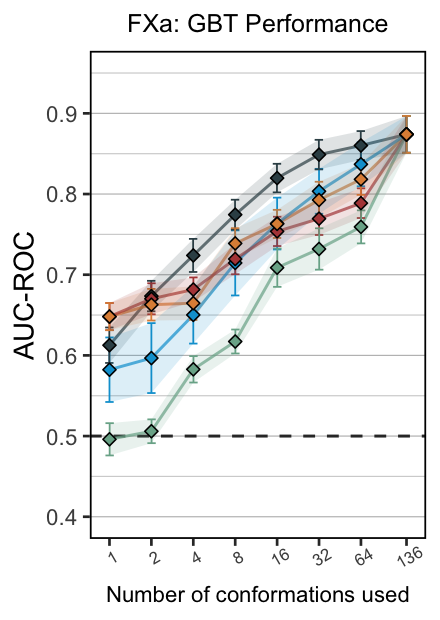

In [39]:
%%R -i full_names -i df_xgb -w 2.2 -h 3.1 --units in -r 200

library(ggsci)

source('./plotSwarmBox.R')
metric_name <- 'AUC-ROC'

x_ticks <- c(1,2,4,8,16,32, 64, 136)

df <- df_xgb %>%
    filter(index %in% x_ticks) %>%
    filter(method %in% c('RFExgb', 'singConfAUC', 'singConfAUC-Worst', 'bigLigMW', 'random'))

p = plot_lines(df, cbbPalette, y_min=0.4, y_max=0.95, line_size=0.5, error_dodge=0.01, error_size=0.3,
               point_size=1.5, add_ribbon=T, ribbon_alpha=0.15,
               y_label=metric_name, base_h_line=0.5, switch_x=FALSE, error_width=1, 
               ticks.text.angle=30, ticks.text.size=6, shape=23, title.size=9,
#                legend.position='right',
               x_label="Number of conformations used") +
               scale_x_continuous(breaks = x_ticks,  trans='log2') +
               scale_color_jama() + scale_fill_jama() +
               ggtitle('FXa: GBT Performance')

# Save the picture
protein_name <- 'fxa'
methodology <- 'conf-selection-XGB'
metric <- 'ROC-AUC'
filename <- paste0('images/fxa/', paste(protein_name, methodology, metric, '.pdf', sep='_'))
ggsave(filename, plot=p, width=2.2, height= 3.1) 
p

### Log Reg

In [40]:
df_LR = pd.concat(dict_df_results.values(), keys=dict_df_results.keys())
df_LR = df_LR.query('method == "Log. Reg."').reset_index(). \
    drop(['method', 'level_1'], axis=1).rename(columns={'level_0': 'method'})

R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

R[write to console]: Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



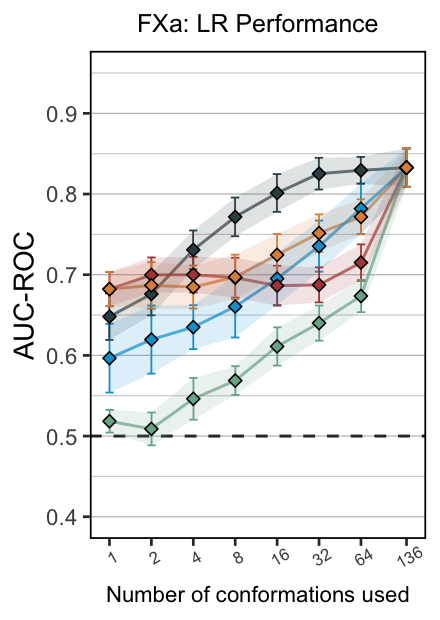

In [41]:
%%R -i full_names -i df_LR -w 2.2 -h 3.1 --units in -r 200

library(ggsci)

source('./plotSwarmBox.R')
metric_name <- 'AUC-ROC'

x_ticks <- c(1,2,4,8,16,32, 64, 136)

df <- df_LR %>%
    filter(index %in% x_ticks) %>%
    filter(method %in% c('RFExgb', 'singConfAUC', 'singConfAUC-Worst', 'bigLigMW', 'random'))

p = plot_lines(df, cbbPalette, y_min=0.4, y_max=0.95, line_size=0.5, error_dodge=0.01, error_size=0.3,
               point_size=1.5, add_ribbon=T, ribbon_alpha=0.15,
               y_label=metric_name, base_h_line=0.5, switch_x=FALSE, error_width=1, 
               ticks.text.angle=30, ticks.text.size=6, shape=23, title.size=9,
               x_label="Number of conformations used") +
               scale_x_continuous(breaks = x_ticks,  trans='log2') +
               scale_color_jama() + scale_fill_jama() +
               ggtitle('FXa: LR Performance')

# Save the picture
protein_name <- 'fxa'
methodology <- 'conf-selection-LR'
metric <- 'ROC-AUC'
filename <- paste0('images/fxa/', paste(protein_name, methodology, metric, '.pdf', sep='_'))
ggsave(filename, plot=p, width=2.2, height= 3.1) 
p

### csMIN

In [42]:
df_MIN = pd.concat(dict_df_results.values(), keys=dict_df_results.keys())
df_MIN = df_MIN.query('method == "csMIN"').reset_index().drop(['method', 'level_1'], axis=1).rename(columns={'level_0': 'method'})

R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

R[write to console]: Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



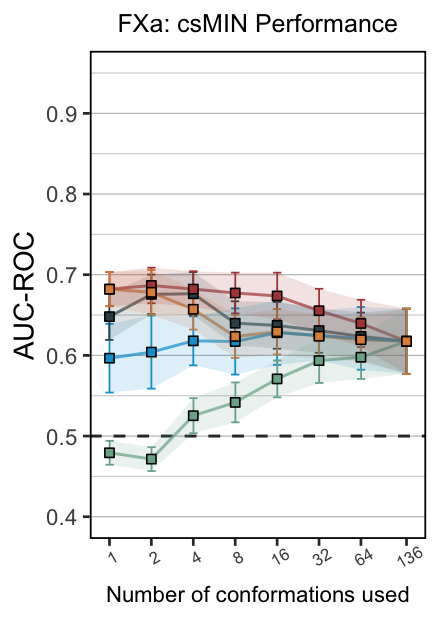

In [43]:
%%R -i full_names -i df_MIN -w 2.2 -h 3.1 --units in -r 200

library(ggsci)

source('./plotSwarmBox.R')
metric_name <- 'AUC-ROC'

x_ticks <- c(1,2,4,8,16,32, 64, 136)

df <- df_MIN %>%
    filter(index %in% x_ticks) %>%
    filter(method %in% c('RFExgb', 'singConfAUC', 'singConfAUC-Worst','bigLigMW', 'random'))
cbbPalette <- hue_pal()(9)

p = plot_lines(df, cbbPalette, y_min=0.4, y_max=0.95, line_size=0.5, error_dodge=0.01, error_size=0.3,
               point_size=1.5, add_ribbon=T, ribbon_alpha=0.15, 
               y_label=metric_name, base_h_line=0.5, switch_x=FALSE, error_width=1, 
               ticks.text.angle=30, ticks.text.size=6, shape=22,title.size=9,
               x_label="Number of conformations used") +
               scale_x_continuous(breaks = x_ticks,  trans='log2') +
               scale_color_jama() + scale_fill_jama() +
               ggtitle('FXa: csMIN Performance')

# Save the picture
protein_name <- 'fxa'
methodology <- 'conf-selection-MIN'
metric <- 'ROC-AUC'
filename <- paste0('images/fxa/', paste(protein_name, methodology, metric, '.pdf', sep='_'))
ggsave(filename, plot=p, width=2.2, height= 3.1) 
p

### csMEAN

In [44]:
df_MEAN = pd.concat(dict_df_results.values(), keys=dict_df_results.keys())
# Debido a un error en los nombres, los resultados de MEAN queraron como de MAX
 # Se queda MAX para MEAN
df_MEAN = df_MEAN.query('method == "csMEAN"')\
    .reset_index().drop(['method', 'level_1'], axis=1).rename(columns={'level_0': 'method'})

R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

R[write to console]: Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



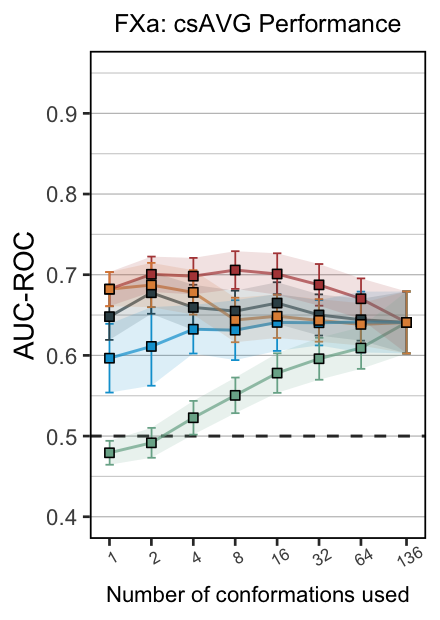

In [45]:
%%R -i full_names -i df_MEAN -w 2.2 -h 3.1 --units in -r 200

library(ggsci)

source('./plotSwarmBox.R')
metric_name <- 'AUC-ROC'

x_ticks <- c(1,2,4,8,16,32, 64, 136)

df <- df_MEAN %>%
    filter(index %in% x_ticks) %>%
    filter(method %in% c('RFExgb', 'singConfAUC', 'singConfAUC-Worst','bigLigMW', 'random'))
cbbPalette <- hue_pal()(9)

p = plot_lines(df, cbbPalette, y_min=0.4, y_max=0.95, line_size=0.5, error_dodge=0.01, error_size=0.3,
               point_size=1.5, add_ribbon=T, ribbon_alpha=0.15, 
               y_label=metric_name, base_h_line=0.5, switch_x=FALSE, error_width=1, 
               ticks.text.angle=30, ticks.text.size=6, shape=22,title.size=9,
               x_label="Number of conformations used") +
               scale_x_continuous(breaks = x_ticks,  trans='log2') +
               scale_color_jama() + scale_fill_jama() +
               ggtitle('FXa: csAVG Performance')

# Save the picture
protein_name <- 'fxa'
methodology <- 'conf-selection-AVG'
metric <- 'ROC-AUC'
filename <- paste0('images/fxa/', paste(protein_name, methodology, metric, '.pdf', sep='_'))
ggsave(filename, plot=p, width=2.2, height= 3.1) 
p

### csMAX

In [46]:
df_MAX = pd.concat(dict_df_results.values(), keys=dict_df_results.keys())
df_MAX = df_MAX.query('method == "csMAX"').reset_index() \
    .drop(['method', 'level_1'], axis=1).rename(columns={'level_0': 'method'})

R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

R[write to console]: Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



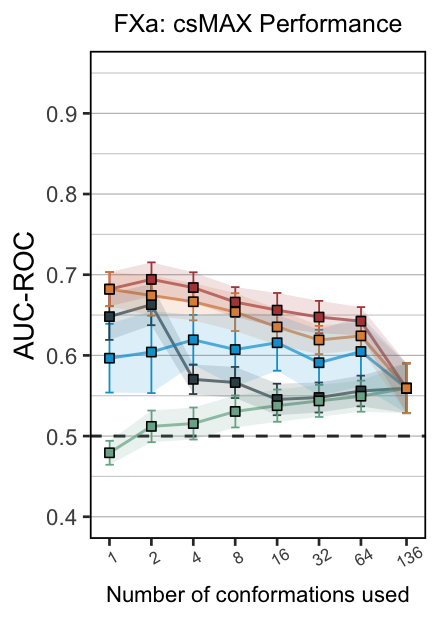

In [47]:
%%R -i full_names -i df_MAX -w 2.2 -h 3.1 --units in -r 200

library(ggsci)

source('./plotSwarmBox.R')
metric_name <- 'AUC-ROC'

x_ticks <- c(1,2,4,8,16,32, 64, 136)

df <- df_MAX %>%
    filter(index %in% x_ticks) %>%
    filter(method %in% c('RFExgb', 'singConfAUC', 'singConfAUC-Worst','bigLigMW', 'random'))
cbbPalette <- hue_pal()(9)

p = plot_lines(df, cbbPalette, y_min=0.4, y_max=0.95, line_size=0.5, error_dodge=0.01, error_size=0.3,
               point_size=1.5, add_ribbon=T, ribbon_alpha=0.15, 
               y_label=metric_name, base_h_line=0.5, switch_x=FALSE, error_width=1, 
               ticks.text.angle=30, ticks.text.size=6, shape=22,title.size=9,
               x_label="Number of conformations used") +
               scale_x_continuous(breaks = x_ticks,  trans='log2') +
               scale_color_jama() + scale_fill_jama() +
               ggtitle('FXa: csMAX Performance')

# Save the picture
protein_name <- 'fxa'
methodology <- 'conf-selection-MAX'
metric <- 'ROC-AUC'
filename <- paste0('images/fxa/', paste(protein_name, methodology, metric, '.pdf', sep='_'))
ggsave(filename, plot=p, width=2.2, height= 3.1) 
p

## NEF

In [48]:
# Format the results into a untidy dataframe
dict_df_results = {test_name: get_group_stats( df, 
                                   metric_name='nef_12_Ra', 
                                   indexes_values=k_values).replace(new_names)
                   for test_name, df in full_results.items()}


### XGB

In [49]:
df_xgb = pd.concat(dict_df_results.values(), keys=dict_df_results.keys())
df_xgb = df_xgb.query('method == "XGB"').reset_index().drop(['method', 'level_1'], 
                                                            axis=1).rename(columns={'level_0': 'method'})

R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

R[write to console]: Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



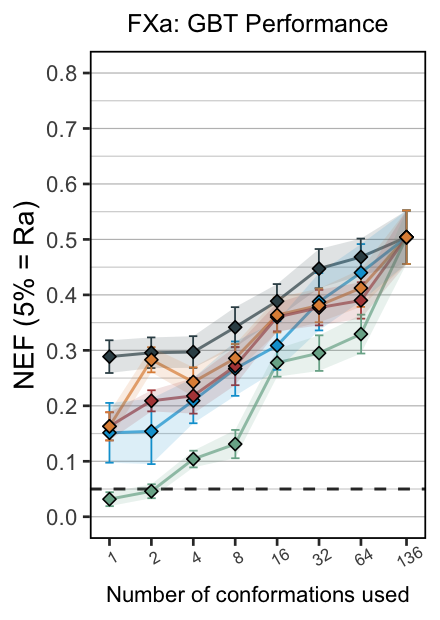

In [50]:
%%R -i full_names -i R_a -i df_xgb -w 2.2 -h 3.1 --units in -r 200

library(ggsci)

source('./plotSwarmBox.R')
metric_name <- 'NEF (5% = Ra)'

x_ticks <- c(1,2,4,8,16,32, 64, 136)

df <- df_xgb %>%
    filter(index %in% x_ticks) %>%
    filter(method %in% c('RFExgb', 'singConfAUC', 'singConfAUC-Worst','bigLigMW', 'random'))

p <- plot_lines(df, cbbPalette, y_min=0.0, y_max=0.8, line_size=0.5, error_dodge=0.01, error_size=0.3,
               point_size=1.5, add_ribbon=T, ribbon_alpha=0.15,
               y_label=metric_name, base_h_line=R_a, switch_x=FALSE, error_width=1, 
               ticks.text.angle=30, ticks.text.size=6, shape=23, title.size=9,
               x_label="Number of conformations used") +
               scale_x_continuous(breaks = x_ticks,  trans='log2') +
               scale_color_jama() + scale_fill_jama() +
               ggtitle('FXa: GBT Performance')

# Save the picture
protein_name <- 'fxa'
methodology <- 'conf-selection-XGB'
metric <- 'NEF'
filename <- paste0('images/fxa/', paste(protein_name, methodology, metric, '.pdf', sep='_'))
ggsave(filename, plot=p, width=2.2, height= 3.1) 
p

### Log Reg

In [51]:
df_LR = pd.concat(dict_df_results.values(), keys=dict_df_results.keys())
df_LR = df_LR.query('method == "Log. Reg."').reset_index().drop(['method', 'level_1'], 
                                                            axis=1).rename(columns={'level_0': 'method'})

R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

R[write to console]: Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



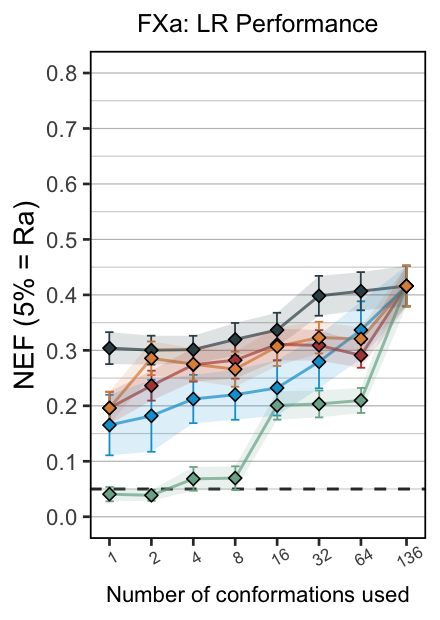

In [52]:
%%R -i full_names -i R_a -i df_LR -w 2.2 -h 3.1 --units in -r 200

library(ggsci)

source('./plotSwarmBox.R')
metric_name <- 'NEF (5% = Ra)'

x_ticks <- c(1,2,4,8,16,32, 64, 136)

df <- df_LR %>%
    filter(index %in% x_ticks) %>%
    filter(method %in% c('RFExgb', 'singConfAUC', 'singConfAUC-Worst','bigLigMW', 'random'))

p <- plot_lines(df, cbbPalette, y_min=0.0, y_max=0.8, line_size=0.5, error_dodge=0.01, error_size=0.3,
               point_size=1.5, add_ribbon=T, ribbon_alpha=0.15,
               y_label=metric_name, base_h_line=R_a, switch_x=FALSE, error_width=1, 
               ticks.text.angle=30, ticks.text.size=6, shape=23, title.size=9,
               x_label="Number of conformations used") +
               scale_x_continuous(breaks = x_ticks,  trans='log2') +
               scale_color_jama() + scale_fill_jama() +
               ggtitle('FXa: LR Performance')

# Save the picture
protein_name <- 'fxa'
methodology <- 'conf-selection-LR'
metric <- 'NEF'
filename <- paste0('images/fxa/', paste(protein_name, methodology, metric, '.pdf', sep='_'))
ggsave(filename, plot=p, width=2.2, height= 3.1) 
p

### csMIN

In [53]:
df_MIN = pd.concat(dict_df_results.values(), keys=dict_df_results.keys())
df_MIN = df_MIN.query('method == "csMIN"').reset_index()\
    .drop(['method', 'level_1'], axis=1).rename(columns={'level_0': 'method'})

R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

R[write to console]: Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



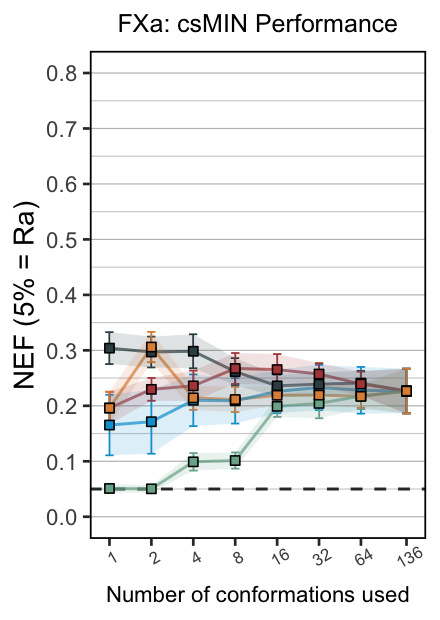

In [54]:
%%R -i full_names -i R_a -i df_MIN -w 2.2 -h 3.1 --units in -r 200

library(ggsci)

source('./plotSwarmBox.R')
metric_name <- 'NEF (5% = Ra)'

x_ticks <- c(1,2,4,8,16,32, 64, 136)

df <- df_MIN %>%
    filter(index %in% x_ticks) %>%
    filter(method %in% c('RFExgb', 'singConfAUC', 'singConfAUC-Worst','bigLigMW', 'random'))

p <- plot_lines(df, cbbPalette, y_min=0.0, y_max=0.8, line_size=0.5, error_dodge=0.01, error_size=0.3,
               point_size=1.5, add_ribbon=T, ribbon_alpha=0.15,
               y_label=metric_name, base_h_line=R_a, switch_x=FALSE, error_width=1, 
               ticks.text.angle=30, ticks.text.size=6, shape=22, title.size=9,
               x_label="Number of conformations used") +
               scale_x_continuous(breaks = x_ticks,  trans='log2') +
               scale_color_jama() + scale_fill_jama() +
               ggtitle('FXa: csMIN Performance')

# Save the picture
protein_name <- 'fxa'
methodology <- 'conf-selection-csMIN'
metric <- 'NEF'
filename <- paste0('images/fxa/', paste(protein_name, methodology, metric, '.pdf', sep='_'))
ggsave(filename, plot=p, width=2.2, height= 3.1) 
p

### csMEAN

In [55]:
df_MEAN = pd.concat(dict_df_results.values(), keys=dict_df_results.keys())
df_MEAN = df_MEAN.query('method == "csMEAN"').\
    reset_index().drop(['method', 'level_1'], axis=1).rename(columns={'level_0': 'method'})

R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

R[write to console]: Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



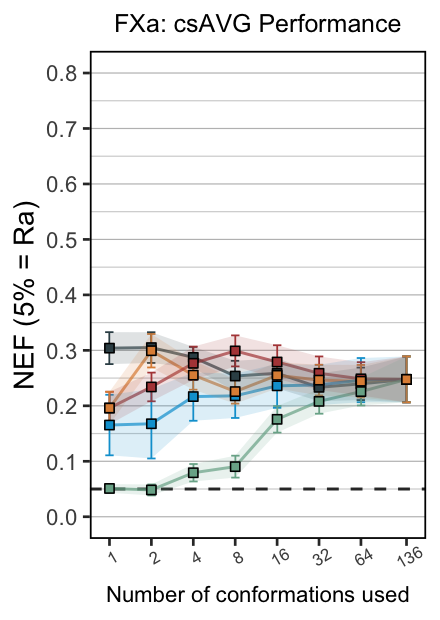

In [56]:
%%R -i full_names -i R_a -i df_MEAN -w 2.2 -h 3.1 --units in -r 200

library(ggsci)

source('./plotSwarmBox.R')
metric_name <- 'NEF (5% = Ra)'

x_ticks <- c(1,2,4,8,16,32, 64, 136)

df <- df_MEAN %>%
    filter(index %in% x_ticks) %>%
    filter(method %in% c('RFExgb', 'singConfAUC', 'singConfAUC-Worst','bigLigMW', 'random'))

p <- plot_lines(df, cbbPalette, y_min=0.0, y_max=0.8, line_size=0.5, error_dodge=0.01, error_size=0.3,
               point_size=1.5, add_ribbon=T, ribbon_alpha=0.15,
               y_label=metric_name, base_h_line=R_a, switch_x=FALSE, error_width=1, 
               ticks.text.angle=30, ticks.text.size=6, shape=22, title.size=9,
               x_label="Number of conformations used") +
               scale_x_continuous(breaks = x_ticks,  trans='log2') +
               scale_color_jama() + scale_fill_jama() +
               ggtitle('FXa: csAVG Performance')

# Save the picture
protein_name <- 'fxa'
methodology <- 'conf-selection-csMEAN'
metric <- 'NEF'
filename <- paste0('images/fxa/', paste(protein_name, methodology, metric, '.pdf', sep='_'))
ggsave(filename, plot=p, width=2.2, height= 3.1) 
p

### csMAX

In [57]:
df_MAX = pd.concat(dict_df_results.values(), keys=dict_df_results.keys())
df_MAX = df_MAX.query('method == "csMAX"').reset_index()\
    .drop(['method', 'level_1'], axis=1).rename(columns={'level_0': 'method'})

R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

R[write to console]: Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



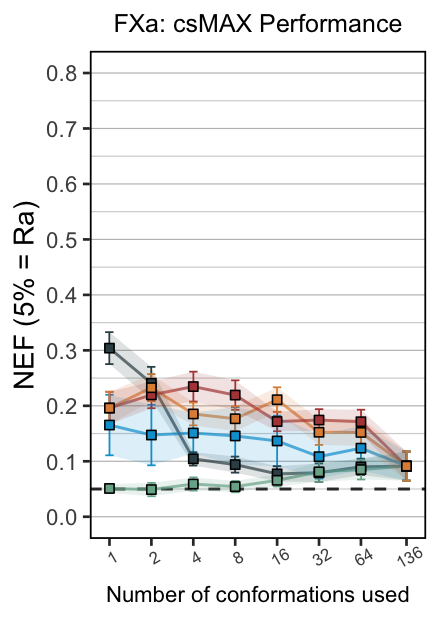

In [58]:
%%R -i full_names -i R_a -i df_MAX -w 2.2 -h 3.1 --units in -r 200

library(ggsci)

source('./plotSwarmBox.R')
metric_name <- 'NEF (5% = Ra)'

x_ticks <- c(1,2,4,8,16,32, 64, 136)

df <- df_MAX %>%
    filter(index %in% x_ticks) %>%
    filter(method %in% c('RFExgb', 'singConfAUC', 'singConfAUC-Worst','bigLigMW', 'random'))

p <- plot_lines(df, cbbPalette, y_min=0.0, y_max=0.8, line_size=0.5, error_dodge=0.01, error_size=0.3,
               point_size=1.5, add_ribbon=T, ribbon_alpha=0.15,
               y_label=metric_name, base_h_line=R_a, switch_x=FALSE, error_width=1, 
               ticks.text.angle=30, ticks.text.size=6, shape=22, title.size=9,
               x_label="Number of conformations used") +
               scale_x_continuous(breaks = x_ticks,  trans='log2') +
               scale_color_jama() + scale_fill_jama() +
               ggtitle('FXa: csMAX Performance')

# Save the picture
protein_name <- 'fxa'
methodology <- 'conf-selection-csMAX'
metric <- 'NEF'
filename <- paste0('images/fxa/', paste(protein_name, methodology, metric, '.pdf', sep='_'))
ggsave(filename, plot=p, width=2.2, height= 3.1) 
p